# Crash course on Nilearn and MVPA (Multi-Variate Pattern Analysis)
In this lesson, we will cover some popular methods in MVPA in the context of brain imaging. Namely,
* <a href="http://www.ncbi.nlm.nih.gov/pmc/articles/PMC1383651/">Searchlight [Nikolaus et al. 2006 (PNAS)]</a>
* <a href="https://hal.inria.fr/hal-01147731/document">Space-Net [Dohmatob et al. 2014 (PRNI)]</a>

Load Haxby 2001 data

In [1]:
from nilearn.datasets import fetch_haxby
data_files = fetch_haxby()

In [2]:
# Load Target labels
import numpy as np
labels = np.recfromcsv(data_files.session_target[0], delimiter=" ")


In [3]:
labels

rec.array([('rest', 0), ('rest', 0), ('rest', 0), ..., ('rest', 11), ('rest', 11),
 ('rest', 11)], 
          dtype=[('labels', 'S12'), ('chunks', '<i8')])

Restrict to face and house conditions

In [4]:
target = labels['labels']
condition_mask = np.logical_or(target == b"face", target == b"house")

Split data into train and test pools

In [5]:
condition_mask_train = np.logical_and(condition_mask, labels['chunks'] <= 6)
condition_mask_test = np.logical_and(condition_mask, labels['chunks'] > 6)
from nilearn.image import index_img
from nilearn.masking import compute_epi_mask
func_filenames = data_files.func[0]
X_train = index_img(func_filenames, condition_mask_train)
X_test = index_img(func_filenames, condition_mask_test)
y_train = target[condition_mask_train]
y_test = target[condition_mask_test]

Compute brain mask and background EPI image

In [6]:
from nilearn.image import mean_img
mask_img = compute_epi_mask(func_filenames)
background_img = mean_img(func_filenames)
background_img.to_filename("bg_img.nii.gz")

Searchlight
============

Prepare masks

* mask_img is the original mask
* process_mask_img is a subset of mask_img, it contains the voxels that should be processed (we only keep the slice z = 26 and the back of the brain to speed up computation)

In [7]:
from nilearn.decoding import SearchLight
from nilearn.image import new_img_like
process_mask = mask_img.get_data().astype(np.int)
picked_slice = 27
process_mask[..., (picked_slice + 1):] = 0
process_mask[..., :picked_slice] = 0
process_mask[:, 30:] = 0
process_mask_img = new_img_like(mask_img, process_mask)


Now, fit a Searchlight model on your data

In [8]:
searchlight = SearchLight(mask_img, process_mask_img=process_mask_img, radius=5.6, verbose=1)
searchlight.fit(X_train, y_train)

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    8.4s finished


SearchLight(cv=None, estimator='svc',
      mask_img=<nibabel.nifti1.Nifti1Image object at 0x7f809d75af10>,
      n_jobs=1,
      process_mask_img=<nibabel.nifti1.Nifti1Image object at 0x7f8070e40f90>,
      radius=5.6, scoring=None, verbose=1)

Plot the model coefficients to see whats really going on.

In [9]:
%matplotlib inline

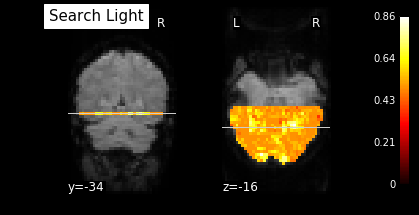

In [10]:
from nilearn.plotting import plot_stat_map, show
coef_img = new_img_like(background_img, searchlight.scores_)
plot_stat_map(coef_img, background_img,
              title="Search Light",
              cut_coords=(-34, -16), display_mode="yz")

SpaceNet
========
* This is a family of priors which simultaneously impose sparsity and structure on the maps of regressor coefficients.
* It includes <a href="http://www.ncbi.nlm.nih.gov/pubmed/23298747">GraphNet [Grosenick et al 2013]</a>, <a href="https://hal.inria.fr/hal-00839984">TV-L1 [Gramfort et al. 2013 (PRNI)]</a>, etc.

![caption](haxby_comp.png)


Formally, the model is
\begin{equation}
\text{minimize}_{\bf{w} \in \mathbb R^p}\mathcal L(y, X\bf{w}) + \alpha (\rho \|\bf{w}\|_1 + (1-\rho) \Omega(\bf{w}))
\end{equation}
where
* $\bf{w} \in \mathbb R^p$ is the vector of model coefficients and $p$ is the number of voxels in the brain mask (say, $p \sim 10^6$ in a full brain mask!)
* $\mathcal L(y, X\bf{w})$ is the loss term. For example $\mathcal L(y, X\bf{w}) = \frac{1}{2}\|X\bf{w} - y\|_2^2$ in regression settings, equals the logistic loss in classification settings, etc.
* $\alpha > 0$ is the regularization parameter and controls and controls the relative importance of the penalty and loss terms. $\rho \in [0, 1]$ is a mixing parameter and controls the tradeoff between sparsity and structure. For example  $\rho = 1$ corresponds to the classical LASSO.
* The penalty term $\|\bf{w}\|_1$ induces sparsity on the model coefficients $\bf{w}$: all coefficients are forced to zero, except the most "predictive" ones!
* $\Omega(\bf{w})$ is a structure inducing penalty on the model coefficients:

For example \begin{equation}\Omega(\bf{w}) = \frac{1}{2}\|\nabla \bf{w}\|_F^2 := \sum_{j=1}^p|(\nabla_x \bf{w})_j|^2 + |(\nabla_y \bf{w})_j|^2 + |(\nabla_z \bf{w})_j|^2\end{equation} in GraphNet / S-Lasso and for TV-L1, we have
\begin{equation}\Omega(\bf{w}) = \|\bf{w}\|_{TV} := \sum_{j=1}^p\sqrt{|(\nabla_x \bf{w})_j|^2 + |(\nabla_y \bf{w})_j|^2 + |(\nabla_z \bf{w})_j|^2}\end{equation}

* GraphNet is Tikhonov regularization on the spatial gradient of the model coefficients $\bf{w}$. It will produce smooth blobs, but no sharp edges.
* TV semi-norm promotes smooth blobs with sharp edges (i.e has a segmentation property, which is a very good thing). However, the resulting model is much harder to optimize than GraphNet.

**GraphNet / S-Lasso**

In [11]:
from nilearn.decoding import SpaceNetClassifier


In [12]:
decoder = SpaceNetClassifier(memory="nilearn_cache", memory_level=2, penalty='graph-net', verbose=1, loss="mse")
decoder.fit(X_train, y_train)
y_pred = decoder.predict(X_test)
accuracy = (y_pred == y_test).mean() * 100.
print("Graph-net classification accuracy : %g%%" % accuracy)

/home/elvis/anaconda2/lib/python2.7/site-packages/sklearn/externals/joblib/hashing.py:197: DeprecationWarning: Changing the shape of non-C contiguous array by
descriptor assignment is deprecated. To maintain
the Fortran contiguity of a multidimensional Fortran
array, use 'a.T.view(...).T' instead
  obj_bytes_view = obj.view(self.np.uint8)
/home/elvis/anaconda2/lib/python2.7/site-packages/sklearn/externals/joblib/hashing.py:197: DeprecationWarning: Changing the shape of non-C contiguous array by
descriptor assignment is deprecated. To maintain
the Fortran contiguity of a multidimensional Fortran
array, use 'a.T.view(...).T' instead
  obj_bytes_view = obj.view(self.np.uint8)
/home/elvis/anaconda2/lib/python2.7/site-packages/sklearn/externals/joblib/hashing.py:197: DeprecationWarning: Changing the shape of non-C contiguous array by
descriptor assignment is deprecated. To maintain
the Fortran contiguity of a multidimensional Fortran
array, use 'a.T.view(...).T' instead
  obj_bytes_view = o

________________________________________________________________________________
[Memory] Calling nilearn.decoding.space_net.path_scores...
path_scores(<function _graph_net_squared_loss at 0x7f806c7780c8>, array([[ 1.280958, ...,  0.069205],
       ..., 
       [-0.421694, ..., -2.454092]], dtype=float32), 
array([-1, ...,  1]), array([[[False, ..., False],
        ..., 
        [False, ..., False]],

       ..., 
       [[False, ..., False],
        ..., 
        [False, ..., False]]], dtype=bool), 
None, [0.5], array([  8, ..., 125]), array([ 0,  1,  2,  3,  4,  5,  6,  7,  9, 10, 11, 12, 13, 14, 15, 16]), { 'max_iter': 1000, 'tol': 0.0001}, debias=False, verbose=1, n_alphas=10, eps=0.001, key=(0, 0), screening_percentile=30.929715190250057, is_classif=False)


.......

______________________________________________________path_scores - 4.7s, 0.1min
________________________________________________________________________________
[Memory] Calling nilearn.decoding.space_net.path_scores...
path_scores(<function _graph_net_squared_loss at 0x7f806c7780c8>, array([[ 1.280958, ...,  0.069205],
       ..., 
       [-0.421694, ..., -2.454092]], dtype=float32), 
array([-1, ...,  1]), array([[[False, ..., False],
        ..., 
        [False, ..., False]],

       ..., 
       [[False, ..., False],
        ..., 
        [False, ..., False]]], dtype=bool), 
None, [0.5], array([  0, ..., 125]), array([ 8, 17, 18, 19, 20, 21, 22, 23, 24, 27, 28, 29, 30, 31, 32, 33]), { 'max_iter': 1000, 'tol': 0.0001}, debias=False, verbose=1, n_alphas=10, eps=0.001, key=(0, 1), screening_percentile=30.929715190250057, is_classif=False)


........

______________________________________________________path_scores - 4.9s, 0.1min
________________________________________________________________________________
[Memory] Calling nilearn.decoding.space_net.path_scores...
path_scores(<function _graph_net_squared_loss at 0x7f806c7780c8>, array([[ 1.280958, ...,  0.069205],
       ..., 
       [-0.421694, ..., -2.454092]], dtype=float32), 
array([-1, ...,  1]), array([[[False, ..., False],
        ..., 
        [False, ..., False]],

       ..., 
       [[False, ..., False],
        ..., 
        [False, ..., False]]], dtype=bool), 
None, [0.5], array([  0, ..., 125]), array([25, 26, 34, 35, 36, 37, 38, 39, 40, 41, 45, 46, 47, 48, 49, 50]), { 'max_iter': 1000, 'tol': 0.0001}, debias=False, verbose=1, n_alphas=10, eps=0.001, key=(0, 2), screening_percentile=30.929715190250057, is_classif=False)


........

______________________________________________________path_scores - 8.5s, 0.1min
________________________________________________________________________________
[Memory] Calling nilearn.decoding.space_net.path_scores...
path_scores(<function _graph_net_squared_loss at 0x7f806c7780c8>, array([[ 1.280958, ...,  0.069205],
       ..., 
       [-0.421694, ..., -2.454092]], dtype=float32), 
array([-1, ...,  1]), array([[[False, ..., False],
        ..., 
        [False, ..., False]],

       ..., 
       [[False, ..., False],
        ..., 
        [False, ..., False]]], dtype=bool), 
None, [0.5], array([  0, ..., 125]), array([42, 43, 44, 51, 52, 53, 54, 55, 56, 57, 58, 63, 64, 65, 66, 67]), { 'max_iter': 1000, 'tol': 0.0001}, debias=False, verbose=1, n_alphas=10, eps=0.001, key=(0, 3), screening_percentile=30.929715190250057, is_classif=False)


........

______________________________________________________path_scores - 6.1s, 0.1min
________________________________________________________________________________
[Memory] Calling nilearn.decoding.space_net.path_scores...
path_scores(<function _graph_net_squared_loss at 0x7f806c7780c8>, array([[ 1.280958, ...,  0.069205],
       ..., 
       [-0.421694, ..., -2.454092]], dtype=float32), 
array([-1, ...,  1]), array([[[False, ..., False],
        ..., 
        [False, ..., False]],

       ..., 
       [[False, ..., False],
        ..., 
        [False, ..., False]]], dtype=bool), 
None, [0.5], array([  0, ..., 125]), array([59, 60, 61, 62, 68, 69, 70, 71, 72, 73, 74, 75, 81, 82, 83, 84]), { 'max_iter': 1000, 'tol': 0.0001}, debias=False, verbose=1, n_alphas=10, eps=0.001, key=(0, 4), screening_percentile=30.929715190250057, is_classif=False)


........

______________________________________________________path_scores - 5.2s, 0.1min
________________________________________________________________________________
[Memory] Calling nilearn.decoding.space_net.path_scores...
path_scores(<function _graph_net_squared_loss at 0x7f806c7780c8>, array([[ 1.280958, ...,  0.069205],
       ..., 
       [-0.421694, ..., -2.454092]], dtype=float32), 
array([-1, ...,  1]), array([[[False, ..., False],
        ..., 
        [False, ..., False]],

       ..., 
       [[False, ..., False],
        ..., 
        [False, ..., False]]], dtype=bool), 
None, [0.5], array([  0, ..., 125]), array([ 76,  77,  78,  79,  80,  85,  86,  87,  88,  89,  90,  91,  92,
        99, 100, 101]), 
{ 'max_iter': 1000, 'tol': 0.0001}, debias=False, verbose=1, n_alphas=10, eps=0.001, key=(0, 5), screening_percentile=30.929715190250057, is_classif=False)


.......

______________________________________________________path_scores - 9.8s, 0.2min
________________________________________________________________________________
[Memory] Calling nilearn.decoding.space_net.path_scores...
path_scores(<function _graph_net_squared_loss at 0x7f806c7780c8>, array([[ 1.280958, ...,  0.069205],
       ..., 
       [-0.421694, ..., -2.454092]], dtype=float32), 
array([-1, ...,  1]), array([[[False, ..., False],
        ..., 
        [False, ..., False]],

       ..., 
       [[False, ..., False],
        ..., 
        [False, ..., False]]], dtype=bool), 
None, [0.5], array([  0, ..., 125]), array([ 93,  94,  95,  96,  97,  98, 102, 103, 104, 105, 106, 107, 108,
       109, 117, 118]), 
{ 'max_iter': 1000, 'tol': 0.0001}, debias=False, verbose=1, n_alphas=10, eps=0.001, key=(0, 6), screening_percentile=30.929715190250057, is_classif=False)


........

______________________________________________________path_scores - 8.5s, 0.1min
________________________________________________________________________________
[Memory] Calling nilearn.decoding.space_net.path_scores...
path_scores(<function _graph_net_squared_loss at 0x7f806c7780c8>, array([[ 1.280958, ...,  0.069205],
       ..., 
       [-0.421694, ..., -2.454092]], dtype=float32), 
array([-1, ...,  1]), array([[[False, ..., False],
        ..., 
        [False, ..., False]],

       ..., 
       [[False, ..., False],
        ..., 
        [False, ..., False]]], dtype=bool), 
None, [0.5], array([  0, ..., 118]), array([110, 111, 112, 113, 114, 115, 116, 119, 120, 121, 122, 123, 124, 125]), { 'max_iter': 1000, 'tol': 0.0001}, debias=False, verbose=1, n_alphas=10, eps=0.001, key=(0, 7), screening_percentile=30.929715190250057, is_classif=False)


........

______________________________________________________path_scores - 4.7s, 0.1min
Time Elapsed: 53.5496 seconds, 0 minutes.


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:   52.6s finished
/home/elvis/anaconda2/lib/python2.7/site-packages/sklearn/externals/joblib/hashing.py:197: DeprecationWarning: Changing the shape of non-C contiguous array by
descriptor assignment is deprecated. To maintain
the Fortran contiguity of a multidimensional Fortran
array, use 'a.T.view(...).T' instead
  obj_bytes_view = obj.view(self.np.uint8)
/home/elvis/anaconda2/lib/python2.7/site-packages/sklearn/externals/joblib/hashing.py:197: DeprecationWarning: Changing the shape of non-C contiguous array by
descriptor assignment is deprecated. To maintain
the Fortran contiguity of a multidimensional Fortran
array, use 'a.T.view(...).T' instead
  obj_bytes_view = obj.view(self.np.uint8)


Graph-net classification accuracy : 97.7778%


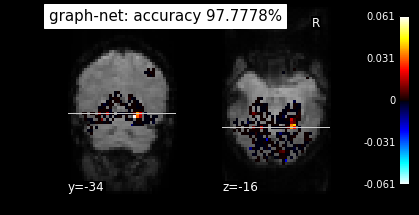

In [13]:
from nilearn.plotting import plot_stat_map, show
coef_img = decoder.coef_img_
plot_stat_map(coef_img, background_img,
              title="graph-net: accuracy %g%%" % accuracy,
              cut_coords=(-34, -16), display_mode="yz")



**TV-L1**

In [14]:
decoder = SpaceNetClassifier(memory="nilearn_cache", memory_level=2, penalty='tv-l1', loss="mse", verbose=1)

In [15]:
decoder.fit(X_train, y_train)
y_pred = decoder.predict(X_test)
accuracy = (y_pred == y_test).mean() * 100.
print("Graph-net classification accuracy : %g%%" % accuracy)

/home/elvis/anaconda2/lib/python2.7/site-packages/sklearn/externals/joblib/hashing.py:197: DeprecationWarning: Changing the shape of non-C contiguous array by
descriptor assignment is deprecated. To maintain
the Fortran contiguity of a multidimensional Fortran
array, use 'a.T.view(...).T' instead
  obj_bytes_view = obj.view(self.np.uint8)
/home/elvis/anaconda2/lib/python2.7/site-packages/sklearn/externals/joblib/hashing.py:197: DeprecationWarning: Changing the shape of non-C contiguous array by
descriptor assignment is deprecated. To maintain
the Fortran contiguity of a multidimensional Fortran
array, use 'a.T.view(...).T' instead
  obj_bytes_view = obj.view(self.np.uint8)
/home/elvis/anaconda2/lib/python2.7/site-packages/sklearn/externals/joblib/hashing.py:197: DeprecationWarning: Changing the shape of non-C contiguous array by
descriptor assignment is deprecated. To maintain
the Fortran contiguity of a multidimensional Fortran
array, use 'a.T.view(...).T' instead
  obj_bytes_view = o

________________________________________________________________________________
[Memory] Calling nilearn.decoding.space_net.path_scores...
path_scores(<functools.partial object at 0x7f806a1ece10>, array([[ 1.280958, ...,  0.069205],
       ..., 
       [-0.421694, ..., -2.454092]], dtype=float32), 
array([-1, ...,  1]), array([[[False, ..., False],
        ..., 
        [False, ..., False]],

       ..., 
       [[False, ..., False],
        ..., 
        [False, ..., False]]], dtype=bool), 
None, [0.5], array([  8, ..., 125]), array([ 0,  1,  2,  3,  4,  5,  6,  7,  9, 10, 11, 12, 13, 14, 15, 16]), { 'max_iter': 1000, 'tol': 0.0001}, debias=False, verbose=1, n_alphas=10, eps=0.001, key=(0, 0), screening_percentile=30.929715190250057, is_classif=False)


..........

_____________________________________________________path_scores - 15.1s, 0.3min
________________________________________________________________________________
[Memory] Calling nilearn.decoding.space_net.path_scores...
path_scores(<functools.partial object at 0x7f806a1ece10>, array([[ 1.280958, ...,  0.069205],
       ..., 
       [-0.421694, ..., -2.454092]], dtype=float32), 
array([-1, ...,  1]), array([[[False, ..., False],
        ..., 
        [False, ..., False]],

       ..., 
       [[False, ..., False],
        ..., 
        [False, ..., False]]], dtype=bool), 
None, [0.5], array([  0, ..., 125]), array([ 8, 17, 18, 19, 20, 21, 22, 23, 24, 27, 28, 29, 30, 31, 32, 33]), { 'max_iter': 1000, 'tol': 0.0001}, debias=False, verbose=1, n_alphas=10, eps=0.001, key=(0, 1), screening_percentile=30.929715190250057, is_classif=False)


.........

_____________________________________________________path_scores - 17.7s, 0.3min
________________________________________________________________________________
[Memory] Calling nilearn.decoding.space_net.path_scores...
path_scores(<functools.partial object at 0x7f806a1ece10>, array([[ 1.280958, ...,  0.069205],
       ..., 
       [-0.421694, ..., -2.454092]], dtype=float32), 
array([-1, ...,  1]), array([[[False, ..., False],
        ..., 
        [False, ..., False]],

       ..., 
       [[False, ..., False],
        ..., 
        [False, ..., False]]], dtype=bool), 
None, [0.5], array([  0, ..., 125]), array([25, 26, 34, 35, 36, 37, 38, 39, 40, 41, 45, 46, 47, 48, 49, 50]), { 'max_iter': 1000, 'tol': 0.0001}, debias=False, verbose=1, n_alphas=10, eps=0.001, key=(0, 2), screening_percentile=30.929715190250057, is_classif=False)


..........

_____________________________________________________path_scores - 20.0s, 0.3min
________________________________________________________________________________
[Memory] Calling nilearn.decoding.space_net.path_scores...
path_scores(<functools.partial object at 0x7f806a1ece10>, array([[ 1.280958, ...,  0.069205],
       ..., 
       [-0.421694, ..., -2.454092]], dtype=float32), 
array([-1, ...,  1]), array([[[False, ..., False],
        ..., 
        [False, ..., False]],

       ..., 
       [[False, ..., False],
        ..., 
        [False, ..., False]]], dtype=bool), 
None, [0.5], array([  0, ..., 125]), array([42, 43, 44, 51, 52, 53, 54, 55, 56, 57, 58, 63, 64, 65, 66, 67]), { 'max_iter': 1000, 'tol': 0.0001}, debias=False, verbose=1, n_alphas=10, eps=0.001, key=(0, 3), screening_percentile=30.929715190250057, is_classif=False)


..........

____________________________________________________path_scores - 110.4s, 1.8min
________________________________________________________________________________
[Memory] Calling nilearn.decoding.space_net.path_scores...
path_scores(<functools.partial object at 0x7f806a1ece10>, array([[ 1.280958, ...,  0.069205],
       ..., 
       [-0.421694, ..., -2.454092]], dtype=float32), 
array([-1, ...,  1]), array([[[False, ..., False],
        ..., 
        [False, ..., False]],

       ..., 
       [[False, ..., False],
        ..., 
        [False, ..., False]]], dtype=bool), 
None, [0.5], array([  0, ..., 125]), array([59, 60, 61, 62, 68, 69, 70, 71, 72, 73, 74, 75, 81, 82, 83, 84]), { 'max_iter': 1000, 'tol': 0.0001}, debias=False, verbose=1, n_alphas=10, eps=0.001, key=(0, 4), screening_percentile=30.929715190250057, is_classif=False)


..........

_____________________________________________________path_scores - 18.9s, 0.3min
________________________________________________________________________________
[Memory] Calling nilearn.decoding.space_net.path_scores...
path_scores(<functools.partial object at 0x7f806a1ece10>, array([[ 1.280958, ...,  0.069205],
       ..., 
       [-0.421694, ..., -2.454092]], dtype=float32), 
array([-1, ...,  1]), array([[[False, ..., False],
        ..., 
        [False, ..., False]],

       ..., 
       [[False, ..., False],
        ..., 
        [False, ..., False]]], dtype=bool), 
None, [0.5], array([  0, ..., 125]), array([ 76,  77,  78,  79,  80,  85,  86,  87,  88,  89,  90,  91,  92,
        99, 100, 101]), 
{ 'max_iter': 1000, 'tol': 0.0001}, debias=False, verbose=1, n_alphas=10, eps=0.001, key=(0, 5), screening_percentile=30.929715190250057, is_classif=False)


..........

_____________________________________________________path_scores - 20.4s, 0.3min
________________________________________________________________________________
[Memory] Calling nilearn.decoding.space_net.path_scores...
path_scores(<functools.partial object at 0x7f806a1ece10>, array([[ 1.280958, ...,  0.069205],
       ..., 
       [-0.421694, ..., -2.454092]], dtype=float32), 
array([-1, ...,  1]), array([[[False, ..., False],
        ..., 
        [False, ..., False]],

       ..., 
       [[False, ..., False],
        ..., 
        [False, ..., False]]], dtype=bool), 
None, [0.5], array([  0, ..., 125]), array([ 93,  94,  95,  96,  97,  98, 102, 103, 104, 105, 106, 107, 108,
       109, 117, 118]), 
{ 'max_iter': 1000, 'tol': 0.0001}, debias=False, verbose=1, n_alphas=10, eps=0.001, key=(0, 6), screening_percentile=30.929715190250057, is_classif=False)


..........

_____________________________________________________path_scores - 18.6s, 0.3min
________________________________________________________________________________
[Memory] Calling nilearn.decoding.space_net.path_scores...
path_scores(<functools.partial object at 0x7f806a1ece10>, array([[ 1.280958, ...,  0.069205],
       ..., 
       [-0.421694, ..., -2.454092]], dtype=float32), 
array([-1, ...,  1]), array([[[False, ..., False],
        ..., 
        [False, ..., False]],

       ..., 
       [[False, ..., False],
        ..., 
        [False, ..., False]]], dtype=bool), 
None, [0.5], array([  0, ..., 118]), array([110, 111, 112, 113, 114, 115, 116, 119, 120, 121, 122, 123, 124, 125]), { 'max_iter': 1000, 'tol': 0.0001}, debias=False, verbose=1, n_alphas=10, eps=0.001, key=(0, 7), screening_percentile=30.929715190250057, is_classif=False)


.........

_____________________________________________________path_scores - 20.1s, 0.3min
Time Elapsed: 242.163 seconds, 4 minutes.


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:  4.0min finished
/home/elvis/anaconda2/lib/python2.7/site-packages/sklearn/externals/joblib/hashing.py:197: DeprecationWarning: Changing the shape of non-C contiguous array by
descriptor assignment is deprecated. To maintain
the Fortran contiguity of a multidimensional Fortran
array, use 'a.T.view(...).T' instead
  obj_bytes_view = obj.view(self.np.uint8)
/home/elvis/anaconda2/lib/python2.7/site-packages/sklearn/externals/joblib/hashing.py:197: DeprecationWarning: Changing the shape of non-C contiguous array by
descriptor assignment is deprecated. To maintain
the Fortran contiguity of a multidimensional Fortran
array, use 'a.T.view(...).T' instead
  obj_bytes_view = obj.view(self.np.uint8)


Graph-net classification accuracy : 97.7778%


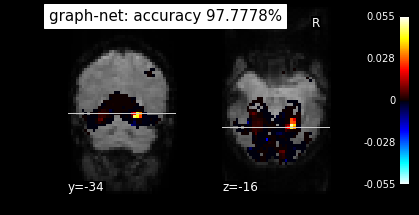

In [16]:
from nilearn.plotting import plot_stat_map, show
coef_img = decoder.coef_img_
plot_stat_map(coef_img, background_img,
              title="graph-net: accuracy %g%%" % accuracy,
              cut_coords=(-34, -16), display_mode="yz")